In [1]:
## TensorFlow untuk membangun dan melatih model deep learning.
## Keras (models, layers) untuk membuat model dan menambahkan lapisan neural network.
## Matplotlib (plt) untuk visualisasi data atau gambar.

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
BATCH_SIZE = 32 ## Menentukan ukuran batch, yaitu jumlah sampel yang diproses sebelum model diperbarui. Setiap batch berisi 32 gambar.
IMAGE_SIZE = 256 ## Menetapkan ukuran gambar yang digunakan untuk pelatihan, yaitu 256x256 piksel.
CHANNELS=3 ## Menunjukkan jumlah kanal warna (3 untuk gambar berwarna RGB: merah, hijau, biru).
EPOCHS=50 ## Menyatakan jumlah epoch atau berapa kali seluruh dataset dilatih selama 50 putaran.

In [3]:
## tf.keras.preprocessing.image_dataset_from_directory: Fungsi untuk membuat dataset gambar dari direktori yang berisi subdirektori untuk setiap kelas.
## "PlantVillage": Lokasi folder dataset gambar yang akan dimuat.
## seed=123: Seed untuk pengacakan, memastikan hasil yang konsisten saat shuffle.
## shuffle=True: Gambar diacak agar urutannya acak dalam batch.
## image_size=(IMAGE_SIZE, IMAGE_SIZE): Gambar diubah ukurannya menjadi 256x256 piksel (nilai dari IMAGE_SIZE).
## batch_size=BATCH_SIZE: Setiap batch memuat 32 gambar (nilai dari BATCH_SIZE).

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
## dataset.class_names: Mengambil daftar nama kelas dari dataset, yaitu subdirektori yang berisi gambar, yang mewakili kategori/label dalam dataset.
## class_names: Variabel ini menyimpan nama-nama kelas tersebut.
## class_names: Menampilkan daftar nama kelas setelah disimpan di variabel.

class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
## for image_batch, labels_batch in dataset.take(1):: Ini mengambil satu batch gambar dan label dari dataset. take(1) mengambil satu batch (ukuran batch sudah ditentukan sebelumnya, yaitu 32 gambar).
## print(image_batch.shape): Menampilkan bentuk/tensor dari batch gambar, yang biasanya berformat (batch_size, image_height, image_width, channels). Contohnya: (32, 256, 256, 3) berarti 32 gambar dengan ukuran 256x256 piksel dan 3 kanal warna (RGB).
## print(labels_batch.numpy()): Menampilkan nilai numerik label dari batch tersebut dalam bentuk array NumPy. Contoh output: [0, 1, 0, 1, ...], di mana setiap angka mewakili kelas gambar.

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


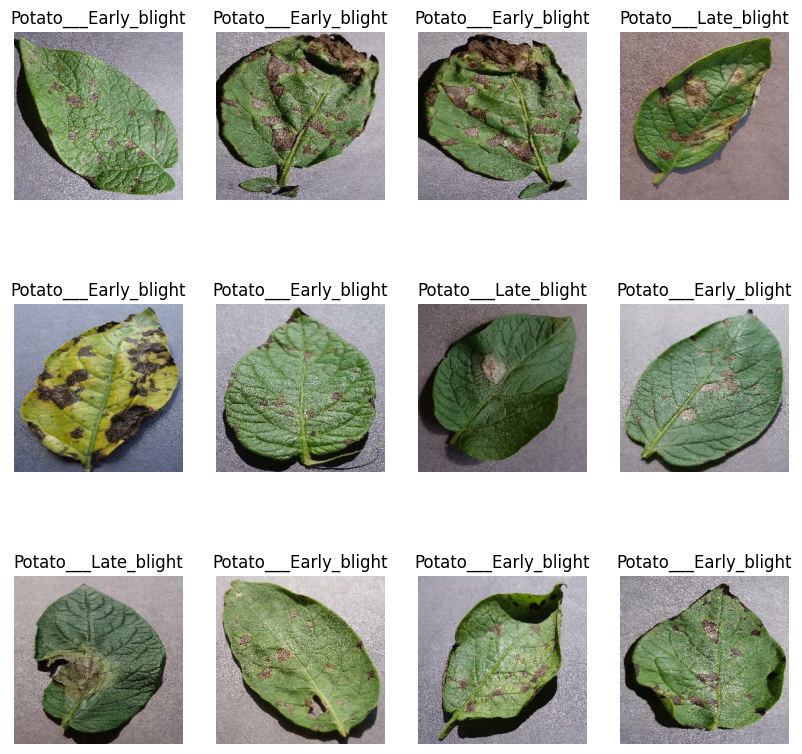

In [6]:
## 

plt.figure(figsize=(10, 10)) ## Membuat sebuah figure berukuran 10x10 inci untuk menampung gambar.
for image_batch, labels_batch in dataset.take(1): ## Mengambil satu batch gambar dan label dari dataset.
    for i in range(12): ## Loop yang mengiterasi sebanyak 12 kali untuk menampilkan 12 gambar dari batch.
        ax = plt.subplot(3, 4, i + 1) ## Membuat grid 3x4 (12 slot) untuk menampilkan gambar dalam subplot yang terpisah.
        plt.imshow(image_batch[i].numpy().astype("uint8")) ## Menampilkan gambar ke-i dari batch dalam format RGB (diubah menjadi uint8 untuk nilai pixel 0-255).
        plt.title(class_names[labels_batch[i]]) ## Menambahkan judul di atas setiap gambar berdasarkan nama kelas yang sesuai dengan label gambar.
        plt.axis("off") ## Menyembunyikan sumbu untuk setiap gambar agar tampilan lebih bersih.

In [7]:
len(dataset) ## digunakan untuk menghitung jumlah batch dalam dataset.

68

In [8]:
train_size = 0.8 ## Menetapkan bahwa 80% dari dataset akan digunakan untuk pelatihan.
len(dataset)*train_size ## Menghitung jumlah batch yang akan dialokasikan untuk pelatihan dengan mengalikan total batch dalam dataset dengan 0.8.

54.400000000000006

In [9]:
train_ds = dataset.take(54) ## Mengambil 54 batch pertama dari dataset asli dan menyimpannya dalam variabel train_ds. Ini berarti dataset pelatihan terdiri dari 54 batch.
len(train_ds) ## Menghitung jumlah batch dalam train_ds.

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8,
                              val_split=0.1,
                              test_split=0.1,
                              shuffle=True,
                              shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu',kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 549ms/step - accuracy: 0.4339 - loss: 1.7569 - val_accuracy: 0.5260 - val_loss: 1.2219
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 622ms/step - accuracy: 0.5333 - loss: 1.1479 - val_accuracy: 0.6458 - val_loss: 0.7919
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 579ms/step - accuracy: 0.7127 - loss: 0.7909 - val_accuracy: 0.6562 - val_loss: 0.8560
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 553ms/step - accuracy: 0.7655 - loss: 0.6636 - val_accuracy: 0.7448 - val_loss: 0.6155
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 496ms/step - accuracy: 0.7893 - loss: 0.5831 - val_accuracy: 0.7448 - val_loss: 0.5808
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 487ms/step - accuracy: 0.8077 - loss: 0.5295 - val_accuracy: 0.8073 - val_loss: 0.5201
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 470ms/step - accuracy: 0.8371 - loss: 0.4534 - val_accuracy: 0.8281 - val_loss: 0.4588
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 569ms/step - accuracy: 0.8650 - loss: 0.3985 - val_accu

In [27]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.9690 - loss: 0.1299


In [28]:
scores

[0.13039419054985046, 0.97265625]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

50

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.553776502609253,
 1.0362374782562256,
 0.7964527010917664,
 0.6484720706939697,
 0.5960819721221924]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

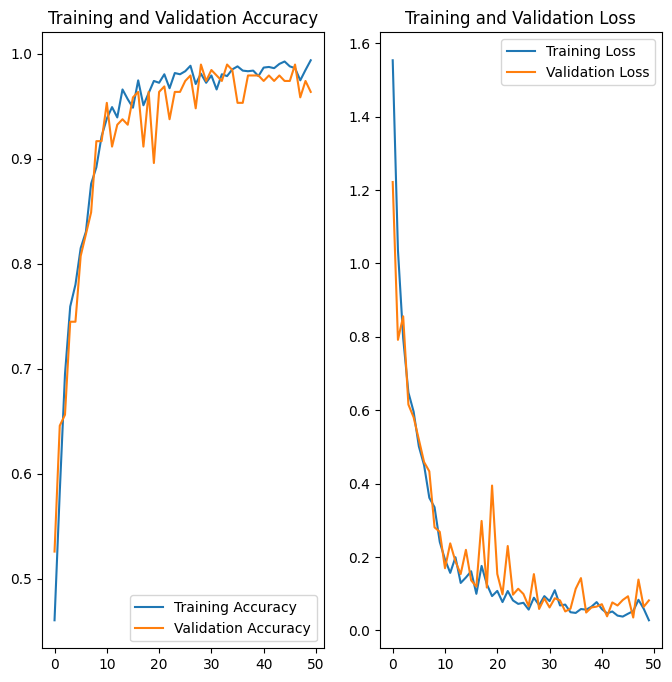

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
predicted label: Potato___Late_blight


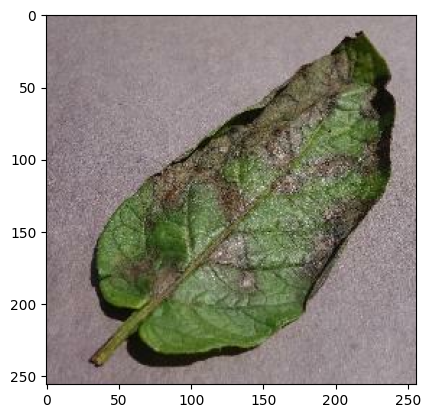

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


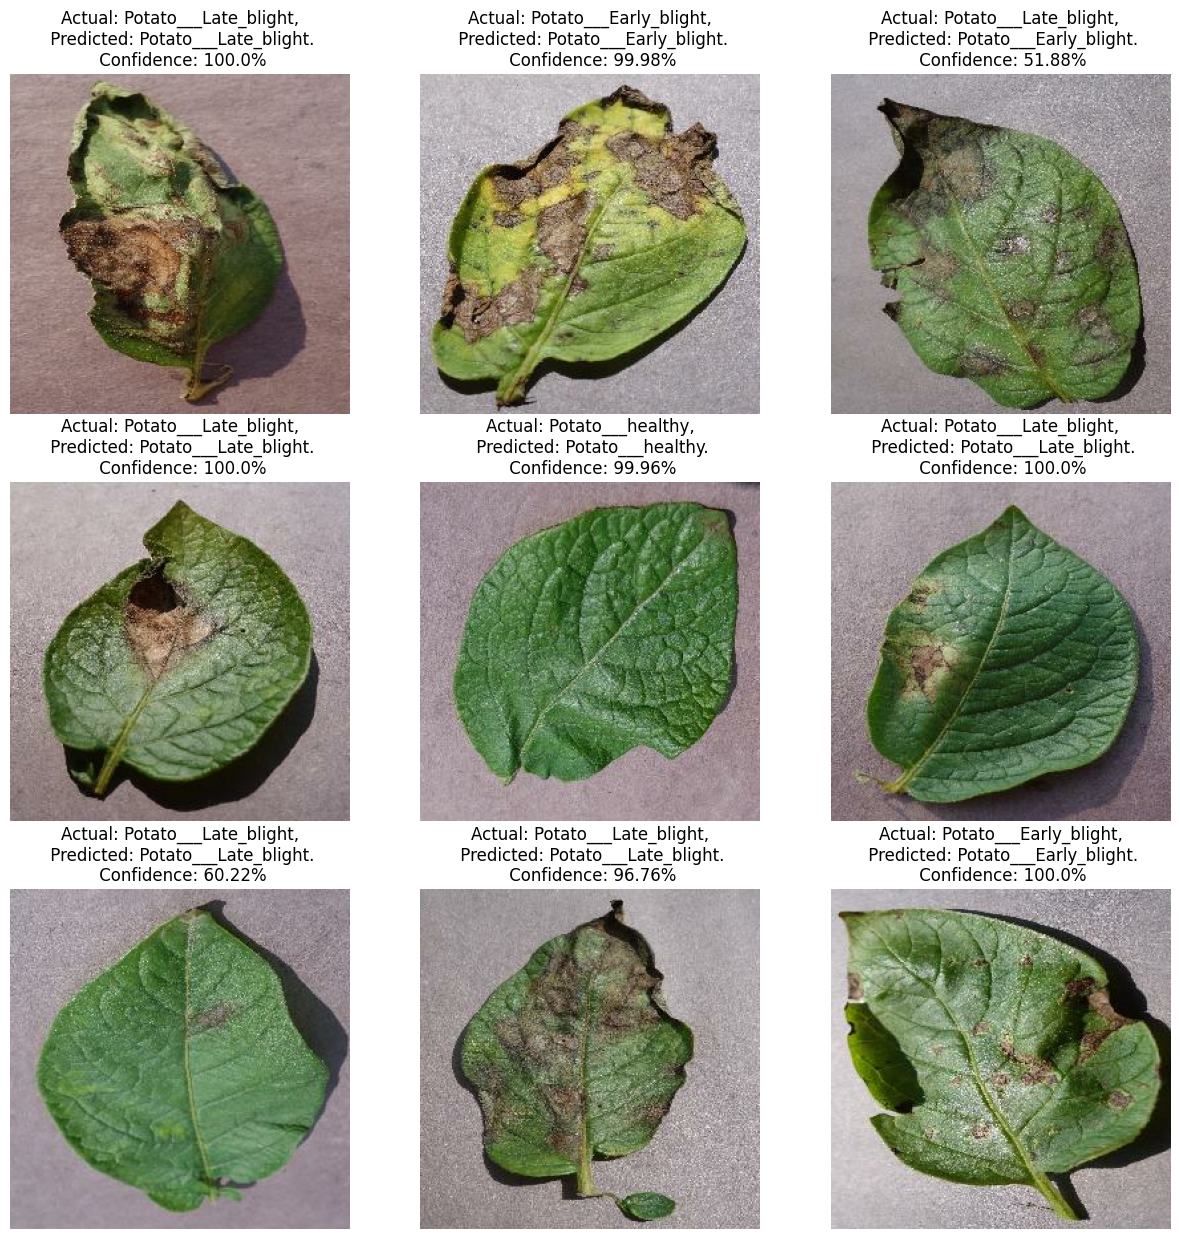

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [40]:
# Buat prediksi untuk test_ds
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


In [41]:
# Ekstrak label yang sebenarnya dari test_ds
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [42]:
# Cetak laporan klasifikasi
print(classification_report(y_true, y_pred_classes, target_names=class_names))

                       precision    recall  f1-score   support

Potato___Early_blight       0.41      0.43      0.42       110
 Potato___Late_blight       0.50      0.48      0.49       128
     Potato___healthy       0.11      0.11      0.11        18

             accuracy                           0.43       256
            macro avg       0.34      0.34      0.34       256
         weighted avg       0.43      0.43      0.43       256



In [43]:
# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

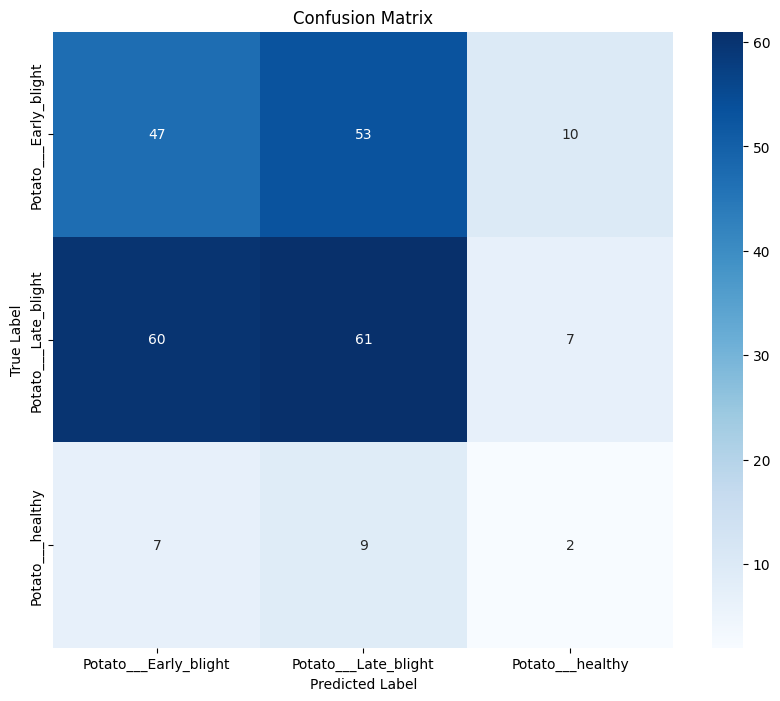

In [44]:
# Visualisasi confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [45]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.41      0.43      0.42       110
           1       0.50      0.48      0.49       128
           2       0.11      0.11      0.11        18

    accuracy                           0.43       256
   macro avg       0.34      0.34      0.34       256
weighted avg       0.43      0.43      0.43       256

